# Decoding DICOM Files

DICOM files are the primary format for storing medical images. All clinical algorithms must be able to read and write DICOM. But these files can be challenging to organize. DICOM files have information associated with the image saved in a header, which can be extensive. Files are structured in 4 tiers:

1. Patient
2. Study
3. Series
4. Instance

DICOM files are unambiguous because each file contains a header that exhaustively documents the hospital, patient, scanner, and image information. <br>

## Challenges of DICOM

For deep learning tasks, the aim is usually to load the image data as a NumPy or other file, and in this case, DICOM can be difficult: 
<br>
* DICOM saves one file per slice, so a 3D scan may have hundreds of files
DICOM files are named with a unique identifier (UID). This makes it hard to sort files from the folder level (in some cases, file names are so long that they exceed the 256 character maximum on Windows computers which causes saving/loading issues)

* Patient and hospital information is embedded in the file header, which can make DICOM tricky to anonymize

Outside the field of informatics, this organizational structure is an important strength of DICOM for medical practice because all information is in one place. 

## Identifying a DICOM file
Each DICOM file is designed to be standalone — all the information needed to identify the file is embedded in each header. This information is organized into 4 levels of hierarchy — patient, study, series, and instance:

* **Patient:** is the person receiving the exam
* **Study:** is the imaging procedure being performed, at a certain date and time, in the hospital
* **Series:** Each study consists of multiple series. A series may represent the patient being physically scanned multiple times in one study (typical for MRI), or it may be virtual, where the patient is scanned once and that data is reconstructed in different ways (typical for CT)

* **Instance:** every slice of a 3D image is treated as a separate instance. In this context, “instance” is synonymous with the DICOM file itself.

<br>

To illustrate this hierarchy we use the "tree" tool to peek into a data folder downloaded from the TGCA-GBM dataset from the publicly available plateform  [The Cancer Imaging Archive (TCIA)](https://www.cancerimagingarchive.net/):  

In [ ]:
!apt-get install tree

In [ ]:
!tree ./TCGA-02-0003/06-08-1997-NA-MRI\ BRAIN\ WW-O\ CONTRAMR-81239 -f 

## Loading the data

In [ ]:
#loading data to VM 
from google.colab import files
uploaded = files.upload()

Saving TCGA-02-0003.zip to TCGA-02-0003.zip


In [ ]:
!unzip -q TCGA-02-0003.zip

# Decoding with Tensorflow IO 

## Install required packages, and restart runtime 

In [ ]:
try:
  # Use the Colab's preinstalled TensorFlow 2.x
  %tensorflow_version 2.x 
except:
  pass

In [ ]:
!pip install tensorflow-io

## Decode DICOM image

### Loading libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_io as tfio

In [ ]:
def show_image(image_path):
  '''Displays a dcm image. The full path of the .dcm image should be given.
  Uses the decode_dicom_image function of tensorflow_io
  The lossy version is autoscaled.'''
  image_bytes = tf.io.read_file(image_path)

  image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

  skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)

  lossy_image = tfio.image.decode_dicom_image(image_bytes, scale='auto', on_error='lossy', dtype=tf.uint8)


  fig, axes = plt.subplots(1,2, figsize=(10,10))
  axes[0].imshow(np.squeeze(image.numpy()), cmap='gray')
  axes[0].set_title('image')
  axes[1].imshow(np.squeeze(lossy_image.numpy()), cmap='gray')
  axes[1].set_title('lossy image'); 

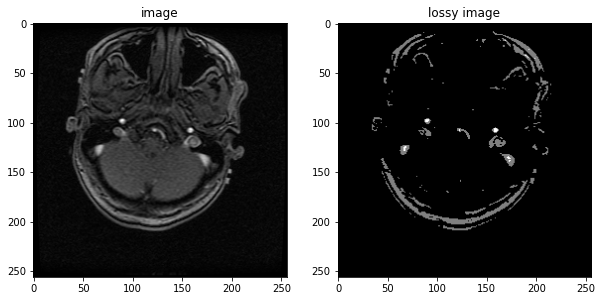

In [ ]:
show_image('/content/TCGA-02-0003/06-08-1997-NA-MRI BRAIN WW-O CONTRAMR-81239/1.000000-3P Localizer-98688/1-1.dcm')

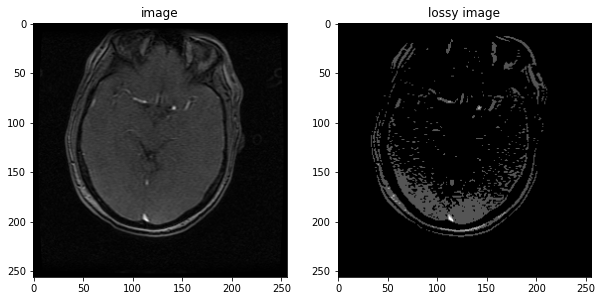

In [ ]:
show_image('/content/TCGA-02-0003/06-08-1997-NA-MRI BRAIN WW-O CONTRAMR-81239/1.000000-3P Localizer-98688/1-2.dcm')

## Decode DICOM metadata
Decode_dicom_data decodes tag information. dicom_tags contains useful information as the patient's age and sex, so you can use DICOM tags such as dicom_tags.PatientsAge and dicom_tags.PatientsSex. tensorflow_io borrow the same tag notation from the pydicom dicom package.

In [ ]:
tag_id = tfio.image.dicom_tags.PatientsAge
tag_value = tfio.image.decode_dicom_data(image_bytes,tag_id)
print(tag_value)

tf.Tensor(b'050Y', shape=(), dtype=string)


In [ ]:
print(f"PatientsAge : {tag_value.numpy().decode('UTF-8')}")

PatientsAge : 050Y


In [ ]:
tag_id = tfio.image.dicom_tags.PatientsSex
tag_value = tfio.image.decode_dicom_data(image_bytes,tag_id)
print(f"PatientsSex : {tag_value.numpy().decode('UTF-8')}")

PatientsSex : M


## DICOM sorter CLI Tool

In [ ]:
# grabbing dicomsorter
!git clone https://github.com/pieper/dicomsort.git

Cloning into 'dicomsort'...
remote: Enumerating objects: 126, done.
remote: Total 126 (delta 0), reused 0 (delta 0), pack-reused 126
Receiving objects: 100% (126/126), 37.03 KiB | 842.00 KiB/s, done.
Resolving deltas: 100% (63/63), done.


## Script

Below is a script from Alex Weston (Digital Innovation Lab, Mayo Clinic) that sorts dicom files using the metadata stored inside the files. <br>
Pydicom and gdcm packages are needed for this script. For the gdcm package, a conda environment is required.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!conda install -c conda-forge gdcm -y

In [ ]:
!conda install -c conda-forge pydicom

In [ ]:
import pydicom
import gdcm

In [ ]:
src = "/content/TCGA-02-0003/06-08-1997-NA-MRI BRAIN WW-O CONTRAMR-81239/12.000000-AX T1-90444" #source folder where the DICOM files are stored
dst = "/content/TCGA-02-0003/06-08-1997-NA-MRI BRAIN WW-O CONTRAMR-81239/AX-T1-90444-pre" # destination folder

print('reading file list...')
unsortedList = []
for root, dirs, files in os.walk(src):
    for file in files: 
        if ".dcm" in file:# exclude non-dicoms, good for messy folders
            unsortedList.append(os.path.join(root, file))

print('%s files found.' % len(unsortedList))

reading file list...
25 files found.


In [ ]:
def clean_text(string):
    '''clean and standardize text descriptions, which makes searching files easier.
    Replacing dangerous characters with underscore.'''
    forbidden_symbols = ["*", ".", ",", "\"", "\\", "/", "|", "[", "]", ":", ";", " "]
    for symbol in forbidden_symbols:
        string = string.replace(symbol, "_") # replace everything with an underscore
    return string.lower()  

for dicom_loc in unsortedList:
    # read the file
    ds = pydicom.read_file(dicom_loc, force=True)
    
    # get patient, study, and series information
    patientID = clean_text(ds.get("PatientID", "NA"))
    studyDate = clean_text(ds.get("StudyDate", "NA"))
    studyDescription = clean_text(ds.get("StudyDescription", "NA"))
    seriesDescription = clean_text(ds.get("SeriesDescription", "NA"))

The file name will be a concatenation of the Modality (CT, MRI, etc.), the Series UID, and the Instance Number. 

In [ ]:
modality = ds.get("Modality","NA")
seriesInstanceUID = ds.get("SeriesInstanceUID","NA")
instanceNumber = str(ds.get("InstanceNumber","0"))
fileName = modality + "." + seriesInstanceUID + "." + instanceNumber + ".dcm"

In [ ]:
# uncompress files (using the gdcm package)
# File types like JPEG2000 can't be decompressed like this so they will be excluded
try:
  ds.decompress()
except:
  print('an instance in file %s - %s - %s - %s" could not be decompressed. exiting.' % (patientID, studyDate, studyDescription, seriesDescription ))

### Full script

In [ ]:
# Alex Weston
# Digital Innovation Lab, Mayo Clinic

import os
import pydicom # pydicom is using the gdcm package for decompression

def clean_text(string):
  '''Clean and standardize text descriptions, which makes searching files easier.
    Replacing dangerous characters with underscore.'''
  forbidden_symbols = ["*", ".", ",", "\"", "\\", "/", "|", "[", "]", ":", ";", " "]
  for symbol in forbidden_symbols:
      string = string.replace(symbol, "_") # replace everything with an underscore
  return string.lower()  
   
# user specified parameters
src = "/content/TCGA-02-0003/06-08-1997-NA-MRI BRAIN WW-O CONTRAMR-81239/12.000000-AX T1-90444"
dst = "/content/TCGA-02-0003/06-08-1997-NA-MRI BRAIN WW-O CONTRAMR-81239/AX-T1-90444-pre"

print('reading file list...')
unsortedList = []
for root, dirs, files in os.walk(src):
  for file in files: 
      if ".dcm" in file:# exclude non-dicoms, good for messy folders
          unsortedList.append(os.path.join(root, file))

print('%s files found.' % len(unsortedList))
       
for dicom_loc in unsortedList:
  # read the file
  ds = pydicom.read_file(dicom_loc, force=True)
   
  # get patient, study, and series information
  patientID = clean_text(ds.get("PatientID", "NA"))
  studyDate = clean_text(ds.get("StudyDate", "NA"))
  studyDescription = clean_text(ds.get("StudyDescription", "NA"))
  seriesDescription = clean_text(ds.get("SeriesDescription", "NA"))
   
  # generate new, standardized file name
  modality = ds.get("Modality","NA")
  studyInstanceUID = ds.get("StudyInstanceUID","NA")
  seriesInstanceUID = ds.get("SeriesInstanceUID","NA")
  instanceNumber = str(ds.get("InstanceNumber","0"))
  fileName = modality + "." + seriesInstanceUID + "." + instanceNumber + ".dcm"
       
  # uncompress files (using the gdcm package)
  try:
      ds.decompress()
  except:
      print('an instance in file %s - %s - %s - %s" could not be decompressed. exiting.' % (patientID, studyDate, studyDescription, seriesDescription ))
   
  # save files to a 4-tier nested folder structure
  if not os.path.exists(os.path.join(dst, patientID)):
      os.makedirs(os.path.join(dst, patientID))
   
  if not os.path.exists(os.path.join(dst, patientID, studyDate)):
      os.makedirs(os.path.join(dst, patientID, studyDate))
       
  if not os.path.exists(os.path.join(dst, patientID, studyDate, studyDescription)):
      os.makedirs(os.path.join(dst, patientID, studyDate, studyDescription))
       
  if not os.path.exists(os.path.join(dst, patientID, studyDate, studyDescription, seriesDescription)):
      os.makedirs(os.path.join(dst, patientID, studyDate, studyDescription, seriesDescription))
      print('Saving out file: %s - %s - %s - %s.' % (patientID, studyDate, studyDescription, seriesDescription ))
       
  ds.save_as(os.path.join(dst, patientID, studyDate, studyDescription, seriesDescription, fileName))

print('done.')

reading file list...
25 files found.
Saving out file: tcga-02-0003 - 19970608 - mri__brain_w&w_o_contramr - ax_t1.
done.


Visualizing th obtained folder structure:

In [ ]:
!tree TCGA-02-0003/06-08-1997-NA-MRI\ BRAIN\ WW-O\ CONTRAMR-81239/AX-T1-90444-pre/ -f

TCGA-02-0003/06-08-1997-NA-MRI BRAIN WW-O CONTRAMR-81239/AX-T1-90444-pre
└── TCGA-02-0003/06-08-1997-NA-MRI BRAIN WW-O CONTRAMR-81239/AX-T1-90444-pre/tcga-02-0003
    └── TCGA-02-0003/06-08-1997-NA-MRI BRAIN WW-O CONTRAMR-81239/AX-T1-90444-pre/tcga-02-0003/19970608
        └── TCGA-02-0003/06-08-1997-NA-MRI BRAIN WW-O CONTRAMR-81239/AX-T1-90444-pre/tcga-02-0003/19970608/mri__brain_w&w_o_contramr
            └── TCGA-02-0003/06-08-1997-NA-MRI BRAIN WW-O CONTRAMR-81239/AX-T1-90444-pre/tcga-02-0003/19970608/mri__brain_w&w_o_contramr/ax_t1
                ├── TCGA-02-0003/06-08-1997-NA-MRI BRAIN WW-O CONTRAMR-81239/AX-T1-90444-pre/tcga-02-0003/19970608/mri__brain_w&w_o_contramr/ax_t1/MR.1.3.6.1.4.1.14519.5.2.1.1706.4001.769579767788431533139923490444.10.dcm
                ├── TCGA-02-0003/06-08-1997-NA-MRI BRAIN WW-O CONTRAMR-81239/AX-T1-90444-pre/tcga-02-0003/19970608/mri__brain_w&w_o_contramr/ax_t1/MR.1.3.6.1.4.1.14519.5.2.1.1706.4001.769579767788431533139923490444.11.dcm
              